In [25]:
import numpy as np
import torch
import torchvision

import math

In [26]:
raw_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=torchvision.transforms.ToTensor())
raw_test = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(raw_test, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
torch.manual_seed(42)

n_samples = 6000 #number of fake images in the virutal dataset per class (same as CIFAR10)

random_state = np.random.default_rng(seed=42)  # for reproducibility
indices2targets = [(i, target) for i, (_, target) in enumerate(raw_train)]
non_iid_alpha = 0.1
num_classes = 10  # CIFAR10 has 10 classes
num_indices = len(raw_train)
n_workers = 10

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
#dirichlet sampling function from VHL codebase
def build_non_iid_by_dirichlet(
    random_state, indices2targets, non_iid_alpha, num_classes, num_indices, n_workers
):
    n_auxi_workers = 10
    assert n_auxi_workers <= n_workers

    # random shuffle targets indices.
    random_state.shuffle(indices2targets)

    # partition indices.
    from_index = 0
    splitted_targets = []
    num_splits = math.ceil(n_workers / n_auxi_workers)
    split_n_workers = [
        n_auxi_workers
        if idx < num_splits - 1
        else n_workers - n_auxi_workers * (num_splits - 1)
        for idx in range(num_splits)
    ]
    split_ratios = [_n_workers / n_workers for _n_workers in split_n_workers]
    for idx, ratio in enumerate(split_ratios):
        to_index = from_index + int(n_auxi_workers / n_workers * num_indices)
        splitted_targets.append(
            indices2targets[
                from_index : (num_indices if idx == num_splits - 1 else to_index)
            ]
        )
        from_index = to_index

    #
    idx_batch = []
    for _targets in splitted_targets:
        # rebuild _targets.
        _targets = np.array(_targets)
        _targets_size = len(_targets)

        # use auxi_workers for this subset targets.
        _n_workers = min(n_auxi_workers, n_workers)
        n_workers = n_workers - n_auxi_workers

        # get the corresponding idx_batch.
        min_size = 0
        while min_size < int(0.50 * _targets_size / _n_workers):
            _idx_batch = [[] for _ in range(_n_workers)]
            for _class in range(num_classes):
                # get the corresponding indices in the original 'targets' list.
                idx_class = np.where(_targets[:, 1] == _class)[0]
                idx_class = _targets[idx_class, 0]

                # sampling.
                try:
                    proportions = random_state.dirichlet(
                        np.repeat(non_iid_alpha, _n_workers)
                    )
                    # balance
                    proportions = np.array(
                        [
                            p * (len(idx_j) < _targets_size / _n_workers)
                            for p, idx_j in zip(proportions, _idx_batch)
                        ]
                    )
                    proportions = proportions / proportions.sum()
                    proportions = (np.cumsum(proportions) * len(idx_class)).astype(int)[
                        :-1
                    ]
                    _idx_batch = [
                        idx_j + idx.tolist()
                        for idx_j, idx in zip(
                            _idx_batch, np.split(idx_class, proportions)
                        )
                    ]
                    sizes = [len(idx_j) for idx_j in _idx_batch]
                    min_size = min([_size for _size in sizes])
                except ZeroDivisionError:
                    pass
        idx_batch += _idx_batch
    return idx_batch

In [29]:
idx_batch = build_non_iid_by_dirichlet(random_state, indices2targets, non_iid_alpha, num_classes, num_indices, n_workers)
for i, idx in enumerate(idx_batch):
  print(len(idx))
client_datasets = [torch.utils.data.DataLoader(raw_train, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(idx)) for idx in idx_batch]

3854
5081
5357
3645
5361
5378
3247
5167
5095
7815


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, args=None, image_size=32, model_input_channels=3, device=None):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.args = args
        self.image_size = image_size
        self.device = device

        self.conv1 = nn.Conv2d(model_input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.layers_name_map = {
            "classifier": "linear"
        }

        inplanes = [64, 64, 128, 256, 512]
        inplanes = [ inplane * block.expansion for inplane in inplanes]
        #logging.info(inplanes)


    def _make_layer(self, block, planes, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    #forward pass copied from resnet in VHL codebase, if statements removed. instead of selecting a layer for feature output, i return features for all layers
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        feat1 = out.view(out.size(0), -1) * 1.0
        out = self.layer2(out)
        feat2 = out.view(out.size(0), -1) * 1.0
        out = self.layer3(out)
        feat3 = out.view(out.size(0), -1) * 1.0
        out = self.layer4(out)
        feat4 = out.view(out.size(0), -1) * 1.0
        out = self.avgpool(out)
        feat_final = out.view(out.size(0), -1) * 1.0
        out = self.linear(out.view(out.size(0), -1))

        return out, feat_final


In [31]:
class ConvNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, num_classes):
        super(ConvNet, self).__init__()
        self.in_channels = in_channels
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels * 2, kernel_size=3, stride=1, padding=1),
            torch.nn.LayerNorm([hidden_channels * 2, 32, 32]),  # Layer normalization instead of batch normalization
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=hidden_channels * 2, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            torch.nn.LayerNorm([hidden_channels, 16, 16]),  # Layer normalization instead of batch normalization
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(hidden_channels * (8 * 8), latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, num_classes)
        )

    def forward(self, x):
      feat = self.encoder(x)
      out = self.decoder(feat)

      return out, feat



In [32]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, contrast_mode='all',
                base_temperature=0.07, device=None):
        super(SupConLoss, self).__init__()

        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.device = device

    def forward(self, features, labels=None, temperature=0.07, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(self.device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(self.device)
        else:
            mask = mask.float().to(self.device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T), temperature)

        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        mask = mask.repeat(anchor_count, contrast_count)

        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(self.device),
            0
        )
        mask = mask * logits_mask

        exp_logits = ( torch.exp(logits) * logits_mask ) + 0.0001

        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        mask_sum = mask.sum(1)
        mask_sum[mask_sum == 0] += 1

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum

        loss = - (temperature / self.base_temperature) * mean_log_prob_pos

        if torch.any(torch.isnan(loss)):
            raise RuntimeError
        loss = loss.view(anchor_count, batch_size).mean()


        return loss

In [33]:
def ipot_WD(a1,a2,C,beta=2,max_iter=1000,L=1,use_path = True, return_map = True, return_loss = True):
    u"""
    Solve the optimal transport problem and return the OT matrix &/or loss.

    References
    ----------

    [1] Xie Y, Wang X, Wang R, et al. A Fast Proximal Point Method for 
    Wasserstein Distance[J]. arXiv preprint arXiv:1802.04307, 2018.
    
    """
    
    # I rewrote it in torch instead of numpy to use GPU
    # Also to handle batch calculations instead of single vector calculations
    epsilon = 1e-6
    batch_size, n = a1.shape

    # Create kernel matrix K
    K = torch.exp(-C / beta)

    # Initialization
    v = torch.ones([batch_size, n, 1], device=C.device)  # Reshaped for batched operations
    u = torch.ones([batch_size, n, 1], device=C.device)  # Reshaped for batched operations
    P = torch.ones((batch_size, n, n), device=C.device) / (n**2)

    loss = []

    for outer_i in range(max_iter):
        Q = K * P

        for _ in range(L):
            u_new = a1.unsqueeze(2) / (torch.bmm(Q, v) + epsilon)
            v_new = a2.unsqueeze(2) / (torch.bmm(Q.transpose(1, 2), u_new) + epsilon)

            u, v = u_new, v_new

        P = u * Q * v.transpose(1, 2)  # Update P respecting batch dimensions

        if return_loss:
            W = torch.sum(P * C, dim=[1, 2])  # Calculate loss for each batch
            loss.append(W)
        # Free up memory
        del Q
        torch.cuda.empty_cache()
                    
    if return_loss == True:
        if return_map == True:
            return P, loss
        else:
            return loss
    else:
        if return_map == True:
            return P
        else:
            return None


In [34]:
class Client:
    def __init__(self, client_id, datasets, device):
        self.client_id = client_id
        self.train_dataset, self.test_dataset = datasets
        self.model = None
        self.device = device
        
    def __len__(self):
        return len(self.dataset)

    def id(self):
        return self.client_id

    def set_model(self, model):
        self.model = model

    def local_update(self, E, LR, MOMENTUM, BETA, LOG_INTERVAL, virtual_dataset, anchors_tensor, etf):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=MOMENTUM)
        self.model.to(self.device)
        supcon = SupConLoss(device=self.device)
        anchor_1_channels = []
        anchor_2_channels = []
        anchor_3_channels = []

        # Split each anchor into its individual channels
        for anchor in anchors_tensor:
            anchor_1, anchor_2, anchor_3 = torch.split(anchor, 1, dim=0)

            anchor_1_channels.append(anchor_1)
            anchor_2_channels.append(anchor_2)
            anchor_3_channels.append(anchor_3)

        anchor_1_channels = torch.stack(anchor_1_channels)
        anchor_2_channels = torch.stack(anchor_2_channels)
        anchor_3_channels = torch.stack(anchor_3_channels)

        i=0

        #there is now just one batch for the virtual dataset of size 10
        for virtual_inputs, virtual_targets in virtual_dataset:
            continue
        
        for epoch in range(1, E + 1):
            clf_losses, info_losses, accs = [], [], []
            for inputs, targets in self.train_dataset:
                i+=1

                sim_list = []
                for (input, target) in zip(inputs, targets):
                    channel_1, channel_2, channel_3 = torch.split(input, 1, dim=0)
                    sim_1 = torch.nn.functional.cosine_similarity(channel_1.to(self.device), anchor_1_channels[target].to(self.device), dim=0)
                    sim_2 = torch.nn.functional.cosine_similarity(channel_2.to(self.device), anchor_2_channels[target].to(self.device), dim=0)
                    sim_3 = torch.nn.functional.cosine_similarity(channel_3.to(self.device), anchor_3_channels[target].to(self.device), dim=0)

                    sim_stack = torch.stack((sim_1.squeeze(0), sim_2.squeeze(0), sim_3.squeeze(0)))
                    sim_list.append(sim_stack)

                inputs = torch.stack(sim_list)

                sim_list = []
                for (input, target) in zip(virtual_inputs, virtual_targets):
                    channel_1, channel_2, channel_3 = torch.split(input, 1, dim=0)
                    sim_1 = torch.nn.functional.cosine_similarity(channel_1.to(self.device), anchor_1_channels[target].to(self.device), dim=0)
                    sim_2 = torch.nn.functional.cosine_similarity(channel_2.to(self.device), anchor_2_channels[target].to(self.device), dim=0)
                    sim_3 = torch.nn.functional.cosine_similarity(channel_3.to(self.device), anchor_3_channels[target].to(self.device), dim=0)

                    sim_stack = torch.stack((sim_1.squeeze(0), sim_2.squeeze(0), sim_3.squeeze(0)))
                    sim_list.append(sim_stack)

                virtual_inputs = torch.stack(sim_list)

                inputs, targets = inputs.to(self.device), targets.long().to(self.device)
                virtual_inputs, virtual_targets = virtual_inputs.to(self.device), virtual_targets.long().to(self.device)

                outputs, feat = self.model(inputs)
                virtual_outputs, vfeat = self.model(virtual_inputs)

                natural_loss = F.cross_entropy(outputs, targets)
                virtual_loss = F.cross_entropy(virtual_outputs, virtual_targets)

                stacked_features = torch.cat((feat, vfeat.detach()))
                stacked_targets = torch.cat((targets, virtual_targets))
                if torch.any(torch.isnan(stacked_features)):
                  print('features: ', torch.any(torch.isnan(stacked_features)))
                discrepancy = supcon(features=stacked_features.unsqueeze(1), labels=stacked_targets)

                # Optimal Transfer Arithmetic //////////////////////////////////////////////////////////////////////////////

                etf_list = []
                for target in stacked_targets:
                    etf_vector = etf[target]
                    etf_list.append(etf_vector)

                etf_equivalent = torch.stack(etf_list)

                a1 = torch.softmax(stacked_features, dim=0).detach()
                a2 = torch.softmax(etf_equivalent, dim=0).to(self.device)

                wasserstein_distances = []
                d1 = a1.unsqueeze(2).unsqueeze(3)

                d2 = a2.unsqueeze(1).unsqueeze(3)

                diff = d1 - d2

                cost_matrix = torch.norm(diff, p=2, dim=3)

                transport_matrix, wasserstein_distance = ipot_WD(a1, a2, cost_matrix.to(self.device))

                wasserstein_sum = sum(wasserstein_distance[-1])
                if torch.isnan(wasserstein_sum).any():
                    print('cause is wasserstein ',wasserstein_sum)
                    
                self.wasserstein_sums.append(wasserstein_sum)
                # Optimal Transfer Arithmetic //////////////////////////////////////////////////////////////////////////////
                self.natural_losses.append(natural_loss.detach())
                self.virtual_losses.append(virtual_loss.detach())
                loss = natural_loss + virtual_loss +  wasserstein_sum #+ (BETA * discrepancy) 

                if torch.isnan(natural_loss).any() or torch.isinf(natural_loss).any():
                    print('cause is natural ',loss)
                if torch.isnan(virtual_loss).any() or torch.isinf(virtual_loss).any():
                    print('cause is virtual ',loss)
                if torch.isnan(discrepancy).any() or torch.isinf(discrepancy).any():
                    print('cause is discrepancy. nans or infs perpetuated through the supcon function. ',loss)
                acc = torch.eq(outputs.max(1)[1], targets).float().mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                clf_losses.append(natural_loss.item())

                accs.append(acc.item())

            avg_clf_loss = torch.tensor(clf_losses).mean().item()
            avg_acc = torch.tensor(accs).mean().item()
            if epoch % LOG_INTERVAL == 0:
              print(f"(CLIENT {self.client_id}) [UPDATE] [EPOCH {epoch}] Classification Loss: {avg_clf_loss:.4f} | Acc: {avg_acc:.4f}")
        self.model.to('cpu')

    def local_update_wasserstein(self, E, LR, MOMENTUM, BETA, LOG_INTERVAL, virtual_dataset, anchors_tensor, etf):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=MOMENTUM)
        self.model.to(self.device)
        supcon = SupConLoss(device=self.device)
        anchor_1_channels = []
        anchor_2_channels = []
        anchor_3_channels = []

        # Split each anchor into its individual channels
        for anchor in anchors_tensor:
            anchor_1, anchor_2, anchor_3 = torch.split(anchor, 1, dim=0)

            anchor_1_channels.append(anchor_1)
            anchor_2_channels.append(anchor_2)
            anchor_3_channels.append(anchor_3)

        anchor_1_channels = torch.stack(anchor_1_channels)
        anchor_2_channels = torch.stack(anchor_2_channels)
        anchor_3_channels = torch.stack(anchor_3_channels)

        i=0

        #there is now just one batch for the virtual dataset of size 10
        for virtual_inputs, virtual_targets in virtual_dataset:
            continue
        
        for epoch in range(1, E + 1):
            clf_losses, info_losses, accs = [], [], []
            for inputs, targets in self.train_dataset:

                sim_list = []
                for (input, target) in zip(inputs, targets):
                    channel_1, channel_2, channel_3 = torch.split(input, 1, dim=0)
                    sim_1 = torch.nn.functional.cosine_similarity(channel_1.to(self.device), anchor_1_channels[target].to(self.device), dim=0)
                    sim_2 = torch.nn.functional.cosine_similarity(channel_2.to(self.device), anchor_2_channels[target].to(self.device), dim=0)
                    sim_3 = torch.nn.functional.cosine_similarity(channel_3.to(self.device), anchor_3_channels[target].to(self.device), dim=0)

                    sim_stack = torch.stack((sim_1.squeeze(0), sim_2.squeeze(0), sim_3.squeeze(0)))
                    sim_list.append(sim_stack)

                inputs = torch.stack(sim_list)

                sim_list = []
                for (input, target) in zip(virtual_inputs, virtual_targets):
                    channel_1, channel_2, channel_3 = torch.split(input, 1, dim=0)
                    sim_1 = torch.nn.functional.cosine_similarity(channel_1.to(self.device), anchor_1_channels[target].to(self.device), dim=0)
                    sim_2 = torch.nn.functional.cosine_similarity(channel_2.to(self.device), anchor_2_channels[target].to(self.device), dim=0)
                    sim_3 = torch.nn.functional.cosine_similarity(channel_3.to(self.device), anchor_3_channels[target].to(self.device), dim=0)

                    sim_stack = torch.stack((sim_1.squeeze(0), sim_2.squeeze(0), sim_3.squeeze(0)))
                    sim_list.append(sim_stack)

                virtual_inputs = torch.stack(sim_list)

                inputs, targets = inputs.to(self.device), targets.long().to(self.device)
                virtual_inputs, virtual_targets = virtual_inputs.to(self.device), virtual_targets.long().to(self.device)

                outputs, feat = self.model(inputs)
                virtual_outputs, vfeat = self.model(virtual_inputs)

                natural_loss = F.cross_entropy(outputs, targets)
                virtual_loss = F.cross_entropy(virtual_outputs, virtual_targets)

                stacked_features = torch.cat((feat, vfeat.detach()))
                stacked_targets = torch.cat((targets, virtual_targets))
                if torch.any(torch.isnan(stacked_features)):
                  print('features: ', torch.any(torch.isnan(stacked_features)))
                discrepancy = supcon(features=stacked_features.unsqueeze(1), labels=stacked_targets)

                # Averaged Wasserstein Distances Used //////////////////////////////////////////////////////////////////////////////
                #batch_size = len(inputs)
                sum_wasserstein = self.wasserstein_sums[i]
                all_natural = self.natural_losses[i]
                all_virtual = self.virtual_losses[i]
                loss = 0.1*natural_loss + all_natural + 0.1*virtual_loss + all_virtual + sum_wasserstein #+ (BETA * discrepancy) 

                if torch.isnan(natural_loss).any() or torch.isinf(natural_loss).any():
                    print('cause is natural ',loss)
                if torch.isnan(virtual_loss).any() or torch.isinf(virtual_loss).any():
                    print('cause is virtual ',loss)
                if torch.isnan(discrepancy).any() or torch.isinf(discrepancy).any():
                    print('cause is discrepancy. nans or infs perpetuated through the supcon function. ',loss)
                acc = torch.eq(outputs.max(1)[1], targets).float().mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                clf_losses.append(natural_loss.item())

                accs.append(acc.item())
            i+=1
            avg_clf_loss = torch.tensor(clf_losses).mean().item()
            avg_acc = torch.tensor(accs).mean().item()
            if epoch % LOG_INTERVAL == 0:
              print(f"(CLIENT {self.client_id}) [UPDATE] [EPOCH {epoch}] Classification Loss: {avg_clf_loss:.4f} | Acc: {avg_acc:.4f}")
        self.model.to('cpu')

    @torch.no_grad()
    def local_evaluate(self, anchors_tensor):
        self.model.to(self.device)
        supcon = SupConLoss()

        anchor_1_channels = []
        anchor_2_channels = []
        anchor_3_channels = []

        # Split each anchor into its individual channels
        for anchor in anchors_tensor:
            anchor_1, anchor_2, anchor_3 = torch.split(anchor, 1, dim=0)

            anchor_1_channels.append(anchor_1)
            anchor_2_channels.append(anchor_2)
            anchor_3_channels.append(anchor_3)

        anchor_1_channels = torch.stack(anchor_1_channels)
        anchor_2_channels = torch.stack(anchor_2_channels)
        anchor_3_channels = torch.stack(anchor_3_channels)

        clf_losses, info_losses, accs = [], [], []
        for inputs, targets in self.test_dataset:
            
            sim_list = []
            for (input, target) in zip(inputs, targets):

                channel_1, channel_2, channel_3 = torch.split(input, 1, dim=0)
                sim_1 = torch.nn.functional.cosine_similarity(channel_1, anchor_1_channels, dim=0)
                sim_2 = torch.nn.functional.cosine_similarity(channel_2, anchor_2_channels, dim=0)
                sim_3 = torch.nn.functional.cosine_similarity(channel_3, anchor_3_channels, dim=0)

                sim_stack = torch.stack((sim_1.squeeze(0), sim_2.squeeze(0), sim_3.squeeze(0)))

                sim_list.append(sim_stack)
            
            inputs = torch.stack(sim_list)
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            outputs, feat = self.model(inputs)

            class_loss = F.cross_entropy(outputs, targets)

            loss = class_loss
            acc = torch.eq(outputs.max(1)[1], targets).float().mean()

            clf_losses.append(class_loss.item())

            accs.append(acc.item())

        avg_clf_loss = torch.tensor(clf_losses).mean().item()

        avg_acc = torch.tensor(accs).mean().item()
        print(f"(CLIENT {self.client_id}) [EVALUATE] Classification Loss: {avg_clf_loss:.4f} | Acc: {avg_acc:.4f}\n")
        self.model.to('cpu')

In [35]:
import copy 

NUM_CLASSES = 10
ANCHORS_PER_CLASS = 20
IN_CHANNELS = 3
HIDDEN_CHANNELS = 16
LATENT_DIM = 200
# ResNet Latent Dim
#LATENT_DIM = 512

placeholder = ''
server = Client('SERVER_MODEL', (placeholder, test_loader), DEVICE)
#server.model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
server.model = ConvNet(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM, NUM_CLASSES)

clients = {}
for i in range(10):
    clients[i] = Client(i, (client_datasets[i], test_loader), DEVICE)
    #clients[i].model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    clients[i].model = copy.deepcopy(server.model)

In [36]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision

class NoiseDataset(Dataset):
    def __init__(self, output_dir, num_samples=6000, num_classes=10, shape=(3, 32, 32)):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.shape = shape
        self.data = []
        self.targets = []
        self.output_dir = output_dir

        # Create the output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)

        for i in range(num_classes):
            c = (np.random.randn(num_samples // 10, *shape).astype(np.float32) * 0.02) + (i * 0.1)
            self.data.append(c)
            self.targets.extend([i] * (num_samples // 10))

            # Save the generated images
            for j in range(num_samples // 10):
                image = c[j]
                image_path = os.path.join(self.output_dir, f"class_{i}", f"image_{j}.png")
                os.makedirs(os.path.dirname(image_path), exist_ok=True)
                torchvision.utils.save_image(torch.tensor(image), image_path)

        self.data = np.concatenate(self.data)
        self.targets = np.array(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return (self.num_samples // 10) * self.num_classes

# Example usage:
#output_dir = "virtual_dataset_images"
#virtual_dataset = NoiseDataset(output_dir=output_dir)


In [37]:
# Utilizes StyleGAN3 to generate images for each class, based on gaussion noise inputs

import os
import torch
import sys

sys.path.append('../')

from training.networks_stylegan3 import Generator

def Generate_StyleGAN_Images():
    # Define the parameters
    z_dim = 512
    c_dim = 0
    w_dim = 512
    img_resolution = 32
    img_channels = 3

    # Instantiate the Generator
    generator = Generator(z_dim=z_dim, c_dim=c_dim, w_dim=w_dim, img_resolution=img_resolution, img_channels=img_channels)

    # Create folder
    output_dir = "StyleGAN_images"
    os.makedirs(output_dir, exist_ok=True)

    # Generate and save images for each class
    class_samples = 1  # Number of images to generate for each distribution
    num_distributions = 10  # Number of Gaussian distributions
    batch_size = 1

    # Generate Gaussian noise
    means = torch.arange(0, num_distributions) 
    print(means)
    noise = torch.stack([torch.randn(z_dim) for _ in range(10)])

    for i in range(num_distributions):
        x = 0
        class_input = noise[i]

        class_vectors = []
        for _ in range(class_samples):
            change = torch.randn(1, z_dim) * 0.1
            new_input = class_input + change
            class_vectors.append(new_input)

        class_vectors_tensor = torch.stack(class_vectors).squeeze(1)

        # Batch the vectors for generation
        batched_class_vectors = torch.split(class_vectors_tensor, batch_size)

        for vectors in batched_class_vectors:
            # Generate images
            with torch.no_grad():
                generated_images = generator(vectors, None)
        
            # Save images in subfolders for different classes
            class_output_dir = os.path.join(output_dir, f"class_{i}")
            os.makedirs(class_output_dir, exist_ok=True)
        
            for j in range(batch_size):

                image_path = os.path.join(class_output_dir, f"image_{j+x}.png")
                generated_image_np = (generated_images[j].detach().cpu().numpy() * 255).astype(np.uint8)
                generated_image_np = generated_image_np.transpose(1, 2, 0)
                
                image = Image.fromarray(generated_image_np)
                image.save(image_path)

            x+=10

    print("Images saved successfully.")
    return 1


In [38]:
import torchvision.transforms as transforms
from PIL import Image

class GeneratedImageDataset(Dataset):
    def __init__(self, folder_path, num_classes):
        self.folder_path = folder_path
        self.num_classes = num_classes
        self.image_paths = []
        self.labels = []

        for class_idx in range(num_classes):
            class_folder = os.path.join(self.folder_path, f"class_{class_idx}")
            image_files = os.listdir(class_folder)
            for image_file in image_files:
                image_path = os.path.join(class_folder, image_file)
                self.image_paths.append(image_path)
                self.labels.append(class_idx)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        # Load image
        image = Image.open(image_path)
        transform = transforms.ToTensor()
        image = transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)


In [39]:
#virtual_dataset = NoiseDataset()
#client_virtual = torch.utils.data.DataLoader(virtual_dataset, batch_size=32, shuffle=True)

#make_imgs = Generate_StyleGAN_Images()
generated_dataset = GeneratedImageDataset(folder_path='StyleGAN_images', num_classes=10)
client_virtual = torch.utils.data.DataLoader(generated_dataset, batch_size=1, shuffle=True)

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_latent(model, anchors, X, y):
    x_tensor = torch.stack(X)
    y_tensor = torch.Tensor(y)

    anchor_1_channels = []
    anchor_2_channels = []
    anchor_3_channels = []

    # Split each anchor into its individual channels
    for anchor in anchors:
        anchor_1, anchor_2, anchor_3 = torch.split(anchor, 1, dim=0)

        anchor_1_channels.append(anchor_1)
        anchor_2_channels.append(anchor_2)
        anchor_3_channels.append(anchor_3)

    anchor_1_channels = torch.stack(anchor_1_channels)
    anchor_2_channels = torch.stack(anchor_2_channels)
    anchor_3_channels = torch.stack(anchor_3_channels)

    sim_list = []
    for inputs, target in zip(x_tensor, y_tensor):
        channel_1, channel_2, channel_3 = torch.split(inputs, 1, dim=0)
        target = int(target)
        sim_1 = torch.nn.functional.cosine_similarity(channel_1, anchor_1_channels, dim=0)
        sim_2 = torch.nn.functional.cosine_similarity(channel_2, anchor_2_channels, dim=0)
        sim_3 = torch.nn.functional.cosine_similarity(channel_3, anchor_3_channels, dim=0)

        sim_stack = torch.stack((sim_1.squeeze(0), sim_2.squeeze(0), sim_3.squeeze(0)))
        sim_list.append(sim_stack)

    inputs = torch.stack(sim_list)
        
    Z = model(inputs)[1].numpy()
    #Z = model(x_tensor)[1].numpy()
    Z = TSNE().fit_transform(X=Z, y=y_tensor)
    plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='tab10')
    plt.show()


In [41]:
def generate_etf(LATENT_DIM, NUM_CLASSES):
    A = torch.randn(LATENT_DIM, NUM_CLASSES)
    P, _ = torch.linalg.qr(A)
    I = torch.eye(NUM_CLASSES)
    O = torch.ones(NUM_CLASSES, NUM_CLASSES)
    M = torch.matmul(P, I.sub(O.mul(1 / NUM_CLASSES))).mul((NUM_CLASSES / (NUM_CLASSES - 1))**0.5)
    return M.T

In [42]:
etf = generate_etf(LATENT_DIM, NUM_CLASSES)

In [43]:
from collections import OrderedDict
import random
from itertools import zip_longest

E = 2
LOG_INTERVAL = 1
LR = 1e-3
MOMENTUM = 0.9
BETA = 1e-3
total_samples = 60010
communication_rounds = 200
num_clients = 10

X = [raw_test[i][0] for i in range(len(raw_test))]
Y = [raw_test[i][1] for i in range(len(raw_test))]

In [44]:

# Server defines an anchor
# Utilizes samples generated from the StyleGAN for anchors
anchors = []

for class_label in range(num_clients):
    sample_index = next(index for index, (data, label) in enumerate(generated_dataset) if label == class_label)
    image_tensor = generated_dataset[sample_index][0]
    image_np = image_tensor.numpy()
    image_float32 = image_np.astype(np.float32)
    # Add a small amount of noise to the image to create anchor
    anchor = torch.Tensor(image_float32 + np.random.randn(*(3, 32, 32)).astype(np.float32) * 0.01)
    anchors.append(anchor)

anchors_tensor = torch.stack(anchors)

In [45]:

data_weights = [(len(clients[i].train_dataset.dataset) + 6000) for i in clients]
total_weight = sum(data_weights)

0
(CLIENT 0) [UPDATE] [EPOCH 1] Classification Loss: 0.4652 | Acc: 0.8347
(CLIENT 0) [UPDATE] [EPOCH 2] Classification Loss: 0.0221 | Acc: 0.9961
(CLIENT 0) [EVALUATE] Classification Loss: 3.9919 | Acc: 0.1004

(CLIENT 1) [UPDATE] [EPOCH 1] Classification Loss: 0.3084 | Acc: 0.8781
(CLIENT 1) [UPDATE] [EPOCH 2] Classification Loss: 0.0304 | Acc: 0.9907
(CLIENT 1) [EVALUATE] Classification Loss: 3.3774 | Acc: 0.0985

(CLIENT 2) [UPDATE] [EPOCH 1] Classification Loss: 0.2317 | Acc: 0.8899
(CLIENT 2) [UPDATE] [EPOCH 2] Classification Loss: 0.0031 | Acc: 0.9998
(CLIENT 2) [EVALUATE] Classification Loss: 5.8765 | Acc: 0.1002

(CLIENT 3) [UPDATE] [EPOCH 1] Classification Loss: 0.5897 | Acc: 0.7917
(CLIENT 3) [UPDATE] [EPOCH 2] Classification Loss: 0.0378 | Acc: 0.9973
(CLIENT 3) [EVALUATE] Classification Loss: 2.8317 | Acc: 0.1017

(CLIENT 4) [UPDATE] [EPOCH 1] Classification Loss: 0.3313 | Acc: 0.8875
(CLIENT 4) [UPDATE] [EPOCH 2] Classification Loss: 0.0183 | Acc: 0.9955
(CLIENT 4) [EVALUA

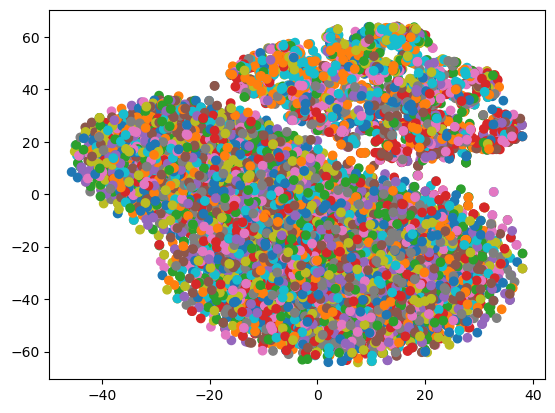

1
(CLIENT 0) [UPDATE] [EPOCH 1] Classification Loss: 0.0787 | Acc: 0.9881
(CLIENT 0) [UPDATE] [EPOCH 2] Classification Loss: 0.0103 | Acc: 0.9964
(CLIENT 0) [EVALUATE] Classification Loss: 3.0103 | Acc: 0.0988

(CLIENT 1) [UPDATE] [EPOCH 1] Classification Loss: 0.0761 | Acc: 0.9955
(CLIENT 1) [UPDATE] [EPOCH 2] Classification Loss: 0.0061 | Acc: 0.9990
(CLIENT 1) [EVALUATE] Classification Loss: 3.2568 | Acc: 0.1014

(CLIENT 2) [UPDATE] [EPOCH 1] Classification Loss: 0.0333 | Acc: 0.9996
(CLIENT 2) [UPDATE] [EPOCH 2] Classification Loss: 0.0013 | Acc: 0.9998
(CLIENT 2) [EVALUATE] Classification Loss: 4.4350 | Acc: 0.1013

(CLIENT 3) [UPDATE] [EPOCH 1] Classification Loss: 0.1884 | Acc: 0.9619
(CLIENT 3) [UPDATE] [EPOCH 2] Classification Loss: 0.0143 | Acc: 1.0000
(CLIENT 3) [EVALUATE] Classification Loss: 2.5266 | Acc: 0.1042

(CLIENT 4) [UPDATE] [EPOCH 1] Classification Loss: 0.0765 | Acc: 0.9898
(CLIENT 4) [UPDATE] [EPOCH 2] Classification Loss: 0.0054 | Acc: 0.9998
(CLIENT 4) [EVALUA

KeyboardInterrupt: 

In [46]:

for rounds in range(communication_rounds):
    print(rounds)
    for i in range(num_clients):
        clients[i].wasserstein_sums = []
        clients[i].natural_losses = []
        clients[i].virtual_losses = []
        clients[i].local_update(E, LR, MOMENTUM, BETA, LOG_INTERVAL, client_virtual, anchors_tensor, etf)
        clients[i].local_evaluate(anchors_tensor)
        clients[i].data_weight = data_weights[i] / total_weight

    # Compute average of Wasserstein distances, natural losses, and virtual losses
    all_sums = [client.wasserstein_sums for client in clients.values()]
    all_natural = [client.natural_losses for client in clients.values()]
    all_virtual = [client.virtual_losses for client in clients.values()]

    averaged_wasserstein = []
    averaged_natural = []
    averaged_virtual = []

    # wasserstein
    for values in zip_longest(*all_sums, fillvalue=None):
        values = [v for v in values if v is not None]  
        averaged_wasserstein.append(sum(values) / len(values))  
    
    # natural
    for values in zip_longest(*all_natural, fillvalue=None):
        values = [v for v in values if v is not None]  
        averaged_natural.append(sum(values) / len(values))

    # virtual
    for values in zip_longest(*all_virtual, fillvalue=None):
        values = [v for v in values if v is not None]  
        averaged_virtual.append(sum(values) / len(values))

    print(torch.isnan(torch.stack(averaged_wasserstein)).any())
    #print(torch.stack(averaged_wasserstein))
    
    for i in range(num_clients):
        clients[i].model.load_state_dict(server.model.state_dict()) # Reinitialize all clients with the base server model
        # Update the local model with the averaged Wasserstein distances and losses
        clients[i].wasserstein_sums = averaged_wasserstein
        clients[i].natural_losses = averaged_natural
        clients[i].virtual_losses = averaged_virtual
        # Perform a local update with the averaged Wasserstein distances and losses
        clients[i].local_update_wasserstein(E, LR, MOMENTUM, BETA, LOG_INTERVAL, client_virtual, anchors_tensor, etf)
        clients[i].local_evaluate(anchors_tensor)
        clients[i].data_weight = data_weights[i] / total_weight

    # FedAVG implementation
    averaged_weights = OrderedDict()
    client_keys = list(clients.keys())  
    selected_keys = random.sample(client_keys, 10) 

    for key in server.model.state_dict().keys():
        averaged_weights[key] = sum(clients[client_key].model.state_dict()[key] * clients[client_key].data_weight for client_key in selected_keys)

    server.model.load_state_dict(averaged_weights)
    plot_latent(server.model, anchors, X, Y)

    for i in range(num_clients):
        clients[i].model.load_state_dict(server.model.state_dict())
